In [78]:
# Basic imports
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os
import pickle
import re
from datetime import datetime
import shutil
from joblib import Parallel, delayed

from scipy.io import loadmat

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="2s", progress_bar=True)

SpikeInterface version: 0.103.2


In [79]:
def extract_datetime(path):
    """
    Extract datetime from a file path containing datetime string in format YYMMDD_HHMMSS.
    
    Parameters
    ----------
    path : str
        Path to extract datetime from.
    
    Returns
    -------
    datetime
        Extracted datetime object. Returns datetime.min if pattern not found.
    """
    m = re.search(r'(\d{6}_\d{6})', path)
    if m:
        return datetime.strptime(m.group(1), "%y%m%d_%H%M%S")
    return datetime.min

In [80]:
# Set base path and load recording data
# basepath = "/local/workdir/ys2375/PreprocessPipeline/data/hp18_day86"
basepath = "/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03"
dataPath = glob.glob(basepath + '/*/amplifier.dat')
dataPath = sorted(dataPath, key=extract_datetime)
display(dataPath)

# Load channel map
chanMapPath = glob.glob(basepath + '/chanMap.mat')[0]

['/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_presleep_251120_094656/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_nostim_251120_113356/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_1_251120_113814/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_2_251120_114305/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_3_251120_114753/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_postsleep_251120_115758/amplifier.dat']

## Mapping channel

[]


(<matplotlib.collections.PolyCollection at 0x7f8b8bf0d810>, None)

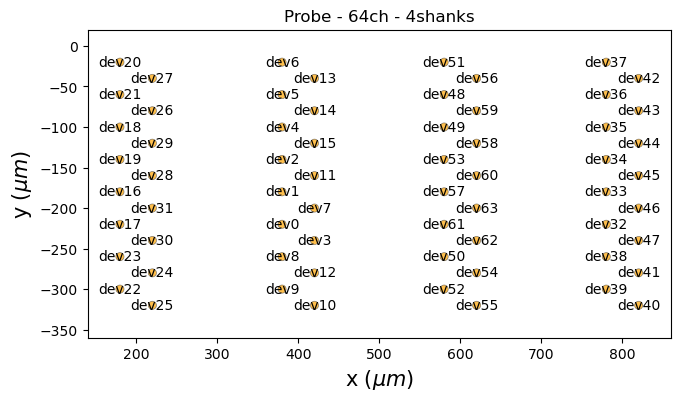

In [81]:
chanMapmat = loadmat(chanMapPath)
x = chanMapmat['xcoords'].flatten()
y = chanMapmat['ycoords'].flatten()
coords = np.column_stack((x, y))
shank_ids = chanMapmat['kcoords'].flatten()
device_ch_inds = chanMapmat['chanMap'].flatten() - 1
bad_ch_ids = np.where(chanMapmat['connected'][:,0]==0)[0]
print(bad_ch_ids)

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(
    positions=coords,
    shapes='circle',
    shape_params={'radius': 5},
    shank_ids=shank_ids
)
probe.set_device_channel_indices(device_ch_inds)

fig, ax = plt.subplots(figsize=(8,4)) 
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)

## Concatenate .dat

In [82]:
# Sampling frequency and channel count
fs = 20000
num_channels = len(probe.device_channel_indices)
recording_list = []

# Read and load each binary recording file
for i in range(len(dataPath)):
    recording_ = se.read_binary(
        dataPath[i],
        sampling_frequency=fs,
        dtype='int16',
        num_channels=num_channels,
        gain_to_uV=0.195,
        offset_to_uV=0
    )
    print(dataPath[i])
    recording_list.append(recording_)

# Concatenate all recordings into single recording object
recording = si.concatenate_recordings(recording_list)

/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_presleep_251120_094656/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_nostim_251120_113356/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_1_251120_113814/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_2_251120_114305/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_3_251120_114753/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_postsleep_251120_115758/amplifier.dat


In [83]:
# Extract the last directory name and save recording using write_binary_recording
file_name = Path(basepath).name + '.dat'
final_dat_path = Path(basepath) / file_name

# Write concatenated binary recording with desired filename
si.write_binary_recording(
    recording,
    file_paths=str(final_dat_path),
    add_file_extension=False,
    verbose=True,
    **job_kwargs
)
print(f"Saved to: {final_dat_path}")

write_binary_recording 
engine=process - n_jobs=506 - samples_per_chunk=40,000 - chunk_memory=4.88 MiB - total_memory=2.41 GiB - chunk_duration=2.00s


write_binary_recording (workers: 506 processes): 100%|██████████| 6065/6065 [00:07<00:00, 812.97it/s] 


Saved to: /local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_day03.dat


## Preprocessing
### Set probe
### Remove bad channel
### Bandpass filter (500 - 8000 Hz)
### Common median filter 
### Artifact removal

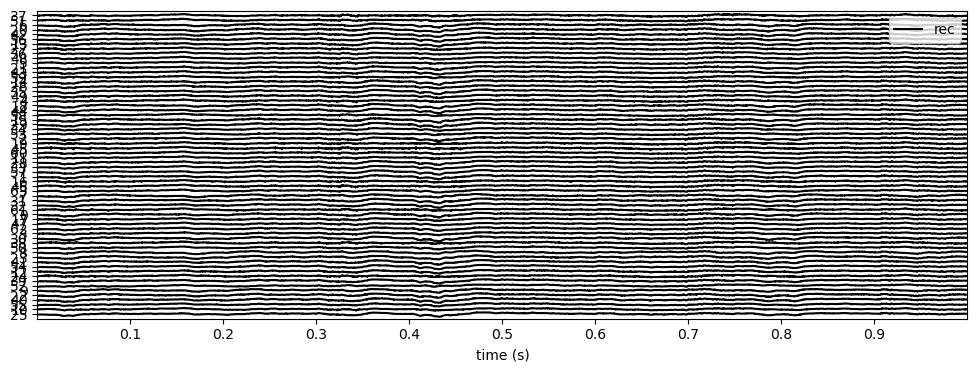

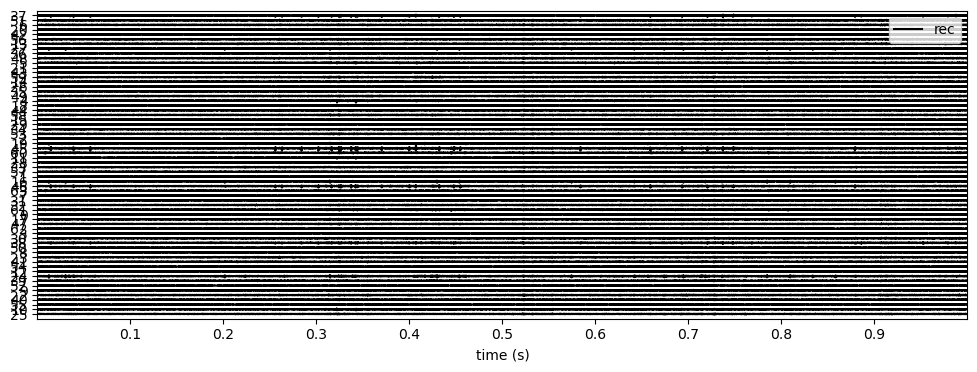

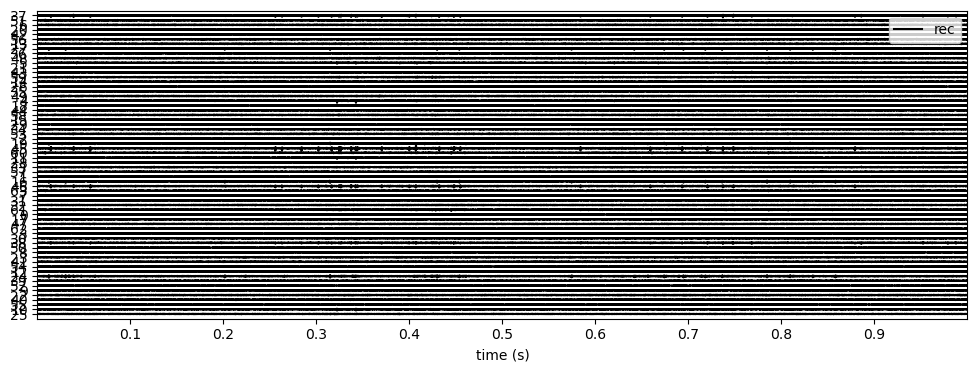

In [84]:
# Set probe and remove bad channels
recording_raw = recording.set_probe(probe, group_mode='by_shank')
recording_raw = recording_raw.remove_channels(remove_channel_ids=bad_ch_ids)

# Plot parameters
tmin = 0
twind = 1
segment_index = 0

# Plot raw traces
sw.plot_traces(
    recording_raw,
    channel_ids=recording_raw.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(12, 4)
)

# Apply bandpass filter (500-8000 Hz)
recording_f = spre.bandpass_filter(recording_raw, freq_min=500, freq_max=8000)
sw.plot_traces(
    recording_f,
    channel_ids=recording_f.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(12, 4)
)

# Apply common median reference (local)
recording_cmr = spre.common_reference(
    recording_f,
    reference='local',
    local_radius=[50, 200],
    operator='median'
)
sw.plot_traces(
    recording_cmr,
    channel_ids=recording_cmr.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(12, 4)
)

In [85]:
def detect_high_amplitude_artifacts(
    recording, 
    by_shank: bool = True,             # If False, treat all channels as a single group
    group_property: str = "group",
    estimate_windows: int = 50,        # Number of random windows used to estimate per-shank noise scale
    estimate_window_s: float = 1.0,    # Duration (s) of each estimation window
    threshold_sigma: float = 20,       # Multiplier on noise scale (MAD→σ) to set amplitude threshold
    seed: int = 0,                     # RNG seed for reproducible window sampling

    chunk_s: float = 5.0,              # Chunk duration (s) for scanning the full recording
    dead_time_ms: float = 100.0,       # Refractory (ms) to merge nearby triggers from the same shank
    n_jobs: int = -1                   # Number of parallel workers for chunk scanning (joblib semantics)
):
    """
    Detect large-amplitude movement/lick artifacts and return trigger frames per shank.
    All steps (threshold estimation, worker definition, parallel scanning, aggregation) are
    performed inside this single function.

    Parameters
    ----------
    recording : si.BaseRecording (or compatible)
        Single-segment recording extractor.
    by_shank : bool, default True
        If True, detect artifacts independently for each shank (using group_property).
        If False, treat all channels as a single group.
    group_property : str, default "group"
        Channel property that encodes shank/cluster membership.
    ... (rest of docstring)
    """
    
    def _worker_scan_chunk_inner(start_frame, end_frame, thresholds_dict, shank_to_inds):
        # Load traces in microvolts for the time window [start_frame, end_frame)
        X = recording.get_traces(
            start_frame=start_frame, 
            end_frame=end_frame, 
            return_in_uV=True
        ).astype(np.float32)

        # For each shank, test the absolute median across its channels against the shank threshold
        candidates = {}
        for sid, ch_inds in shank_to_inds.items():
            if ch_inds.size == 0 or sid not in thresholds_dict:
                continue

            th_amp = thresholds_dict[sid]
            
            # Median across channels for each timepoint (robust to per-channel outliers)
            m = np.median(X[:, ch_inds], axis=1)
            
            violation_mask = np.abs(m) > th_amp
            violation_inds = np.flatnonzero(violation_mask)

            if violation_inds.size > 0:
                # Convert local indices to global frame indices
                candidates[sid] = violation_inds + start_frame
        return candidates

    # ----------------------------------------------------
    
    assert recording.get_num_segments() == 1, "Single segment only supported"
    
    sf = recording.get_sampling_frequency()
    T = recording.get_total_samples()
    dead_time_samp = int(dead_time_ms * 1e-3 * sf)

    ch_ids = recording.get_channel_ids()
    
    if by_shank:
        try:
            # Per-channel shank ids (same order/length as ch_ids)
            shank_ids = np.asarray(recording.get_property(group_property))
        except Exception:
            # Fallback: all channels belong to shank 0
            shank_ids = np.zeros(len(ch_ids), dtype=int)
    else:
        # Treat all channels as a single group
        shank_ids = np.zeros(len(ch_ids), dtype=int)
    
    unique_shanks = np.unique(shank_ids)
    shank_to_inds = {int(s): np.where(shank_ids == s)[0] for s in unique_shanks}

    print(f"Detecting artifacts on {len(unique_shanks)} groups (by_shank={by_shank})...")

    # -------------------- threshold estimation --------------------
    print("Estimating thresholds...")
    thresholds = {}
    rng = np.random.default_rng(seed)
    W_est = int(estimate_window_s * sf)

    for sid in unique_shanks:
        idx = shank_to_inds[sid]
        if idx.size == 0:
            continue

        sub = recording.select_channels(channel_ids=ch_ids[idx])
        # Sample random, nonoverlapping starting points for estimation windows
        starts = rng.integers(0, max(1, T - W_est - 1), size=estimate_windows)
        pool_abs = []
        
        for s in starts:
            # Load window and compute time-wise median across channels
            X_est = sub.get_traces(start_frame=int(s), end_frame=int(s+W_est), return_in_uV=True).astype(np.float32).T
            m = np.median(X_est, axis=0)
            m = m - np.median(m)
            pool_abs.append(np.abs(m))
        
        if not pool_abs:
            # Degenerate case: set an extremely high threshold to avoid false positives
            thresholds[int(sid)] = 1e6
            continue
            
        abs_vals = np.concatenate(pool_abs)
        sigma = 1.4826 * np.median(abs_vals)   # MAD → σ
        thresholds[int(sid)] = sigma * threshold_sigma

    # -------------------- scanning --------------------
    print(f"Scanning recording using backend='threading' (n_jobs={n_jobs})...")
    chunk_len = int(chunk_s * sf)
    chunks = []
    beg = 0
    while beg < T:
        end = min(T, beg + chunk_len)
        chunks.append((beg, end))
        beg = end

    # Parallel chunk scan; returns a list of dicts: shank_id -> trigger frames (local→global)
    results = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(_worker_scan_chunk_inner)(
            start, end, thresholds, shank_to_inds
        ) 
        for start, end in chunks
    )

    # -------------------- aggregation & dead-time merge --------------------
    all_candidates = {int(s): [] for s in unique_shanks}
    for res in results:
        for sid, inds in res.items():
            all_candidates[sid].append(inds)

    final_triggers = {}
    total_artifacts = 0

    for sid in unique_shanks:
        if not all_candidates[sid]:
            final_triggers[sid] = []
            print(f"  Group {sid}: 0 artifacts detected")
            continue
            
        candidates = np.concatenate(all_candidates[sid])
        candidates.sort()
        
        # Enforce dead time on a per-shank basis
        filtered = []
        last_trig = -dead_time_samp * 2

        for t in candidates:
            if t - last_trig > dead_time_samp:
                filtered.append(int(t))
                last_trig = t
        
        final_triggers[sid] = filtered
        n_art = len(filtered)
        total_artifacts += n_art
        print(f"  Group {sid}: {n_art} artifacts detected")

    print(f"Done. Total artifacts detected: {total_artifacts}")
    return final_triggers


def remove_artifacts(
    recording_in: si.BaseRecording,
    artifact_per_shank: dict[int, list[int]],
    by_shank: bool = True,         # If False, treat all channels as a single group
    group_property: str = "group",
    ms_before: float = 0.5,        # Window start relative to trigger (ms; positive values look back in time)
    ms_after: float = 3.0,         # Window end relative to trigger (ms; positive values look forward in time)
    mode: str = "cubic",           # Interpolation strategy: 'cubic' | 'linear' | 'mean' (SI >= 0.98)
):
    """
    Apply `spre.remove_artifacts` independently per shank (or globally), then stitch channels back together.

    Parameters
    ----------
    recording_in : si.BaseRecording
        Single-segment input recording extractor.
    artifact_per_shank : dict[int, list[int]]
        Mapping shank_id -> list of trigger frames (global timeline) to remove.
    by_shank : bool, default True
        If True, apply removal independently for each shank.
        If False, apply removal to all channels simultaneously using triggers from key 0.
    group_property : str, default "group"
        Channel property that encodes shank/cluster membership.
    ... (rest of docstring)
    """
    assert recording_in.get_num_segments() == 1, "single-segment only"

    sf = recording_in.get_sampling_frequency()
    ch_ids = recording_in.get_channel_ids()

    # --- group (shank) assignment ---
    try:
        original_shank_ids = np.asarray(recording_in.get_property(group_property))
        if original_shank_ids.shape[0] != len(ch_ids):
            raise ValueError("group_property length mismatch")
    except Exception:
        original_shank_ids = np.zeros(len(ch_ids), dtype=int)

    if by_shank:
        process_shank_ids = original_shank_ids
    else:
        process_shank_ids = np.zeros(len(ch_ids), dtype=int)

    # Build shank -> channel indices (preserve original channel order)
    shank_to_inds = {int(s): np.where(process_shank_ids == s)[0] for s in np.unique(process_shank_ids)}
    # Determine deterministic shank order as they appear along channels
    ordered_sids = sorted(shank_to_inds.keys(), key=lambda s: (shank_to_inds[s][0] if shank_to_inds[s].size else 1e18))

    cleaned_subs = []
    details = {}

    for sid in ordered_sids:
        idx = shank_to_inds[sid]
        if idx.size == 0:
            continue

        # Sub-recording for this shank (keeps properties)
        sh_ch_ids = ch_ids[idx]
        sub_rec = recording_in.select_channels(channel_ids=sh_ch_ids)

        # Triggers for this shank (frames). Deduplicate & sort.
        # If by_shank=False, we expect triggers in key 0.
        trig = artifact_per_shank.get(int(sid), [])
        if trig:
            trig = np.unique(np.asarray(trig, dtype=np.int64)).tolist()

        if trig:
            # Apply artifact removal on this shank only
            sub_clean = spre.remove_artifacts(
                sub_rec,
                list_triggers=trig,     # frames on the full recording timeline
                ms_before=ms_before,
                ms_after=ms_after,
                mode=mode,
            )
            details[int(sid)] = {
                "n_triggers": len(trig),
                "ms_before": ms_before,
                "ms_after": ms_after,
                "mode": mode,
                "channel_ids": sh_ch_ids.tolist(),
            }
        else:
            # No triggers -> passthrough
            sub_clean = sub_rec
            details[int(sid)] = {
                "n_triggers": 0,
                "ms_before": ms_before,
                "ms_after": ms_after,
                "mode": mode,
                "channel_ids": sh_ch_ids.tolist(),
            }

        cleaned_subs.append(sub_clean)

    # Aggregate channels back (keeps original order by our shank ordering + in-shank order)
    recording_clean = si.aggregate_channels(cleaned_subs)

    # Re-apply original group property on the aggregated recording
    try:
        agg_ch_ids = recording_clean.get_channel_ids()
        gid_map = {int(ch_ids[i]): int(original_shank_ids[i]) for i in range(len(ch_ids))}
        agg_groups = [gid_map[int(ch)] for ch in agg_ch_ids]
        recording_clean.set_channel_property(agg_ch_ids, group_property, agg_groups)
    except Exception:
        pass

    return recording_clean, details

In [91]:
triggers = detect_high_amplitude_artifacts(
    recording_cmr,
    by_shank=False,
    group_property="group",
    estimate_windows=50,       
    threshold_sigma=10,      
    chunk_s=100,               
    dead_time_ms=10.0,        
    n_jobs=-1                  
)

Detecting artifacts on 1 groups (by_shank=False)...
Estimating thresholds...


Scanning recording using backend='threading' (n_jobs=-1)...
  Group 0: 1093 artifacts detected
Done. Total artifacts detected: 1093


In [96]:
recording_clean, info = remove_artifacts(
    recording_in=recording_cmr,              
    artifact_per_shank=triggers,
    by_shank = False,   
    group_property="group",
    ms_before=1,
    ms_after=1,
    mode="cubic",
)

In [97]:
def plot_traces_around_ttl_compare(
    recording_before,
    recording_after,
    ttl_times,
    *,
    before_ms: float = 5.0,
    after_ms: float = 5.0,
    units: str = "s",
    segment_index: int = 0,
    channel_ids=None,
    order_channel_by_depth: bool = True,
    show_channel_ids: bool = True,
    color_groups: bool = False,
    figsize: tuple = (12, 6),
    n_max: int | None = None,
):
    """
    Plots 'Before' and 'After' traces side-by-side for each TTL event.
    Ensures only common channels are plotted to avoid mismatches.
    """
    # 1. Basic validation
    assert recording_before.get_num_segments() > segment_index
    assert recording_after.get_num_segments() > segment_index

    sf = recording_before.get_sampling_frequency()
    total_samples = recording_after.get_num_frames(segment_index=segment_index)
    total_time = total_samples / sf

    # 2. Convert TTL times to seconds
    ttl_times = np.asarray(ttl_times, dtype=float)
    if units == "frames":
        ttl_times = ttl_times / sf

    # 3. Define time window
    t_before = before_ms / 1000.0
    t_after = after_ms / 1000.0

    # 4. Handle Channel IDs (Intersection logic)
    # Get IDs from both recordings to ensure existence
    ids_bef = recording_before.get_channel_ids()
    ids_aft = recording_after.get_channel_ids()
    
    # Find common channels
    common_ids = np.intersect1d(ids_bef, ids_aft)

    # Filter by user selection if provided
    if channel_ids is not None:
        target_ids = np.asarray(channel_ids)
        common_ids = np.intersect1d(common_ids, target_ids)
    
    if len(common_ids) == 0:
        raise ValueError("No common channels found between recordings.")

    # Sort IDs to ensure consistent plotting order
    # (Try numerical sort first, fallback to string sort)
    try:
        sorted_indices = np.argsort(common_ids.astype(int))
        final_channel_ids = common_ids[sorted_indices]
    except ValueError:
        final_channel_ids = np.sort(common_ids)

    # 5. Subsample TTLs if limit is set
    if n_max is not None and len(ttl_times) > n_max:
        idxs = np.linspace(0, len(ttl_times) - 1, n_max, dtype=int)
        ttl_times = ttl_times[idxs]

    # 6. Plotting Loop
    for t0 in ttl_times:
        tmin = max(0.0, t0 - t_before)
        tmax = min(total_time, t0 + t_after)
        
        if tmax <= tmin:
            continue

        # Create figure with 2 columns. sharey=False prevents scaling issues.
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=False)

        plot_kwargs = dict(
            channel_ids=final_channel_ids,
            order_channel_by_depth=order_channel_by_depth,
            show_channel_ids=show_channel_ids,
            time_range=[tmin, tmax],
            segment_index=segment_index,
            color_groups=color_groups,
            backend='matplotlib',
        )

        # Plot Before (Left)
        sw.plot_traces(recording_before, ax=ax1, **plot_kwargs)
        ax1.set_title(f"Before (t={t0:.4f}s)")
        ax1.axvline(t0, color='r', linestyle='--', alpha=0.7, lw=1)

        # Plot After (Right)
        sw.plot_traces(recording_after, ax=ax2, **plot_kwargs)
        ax2.set_title(f"After (t={t0:.4f}s)")
        ax2.axvline(t0, color='r', linestyle='--', alpha=0.7, lw=1)

        plt.tight_layout()
        plt.show()

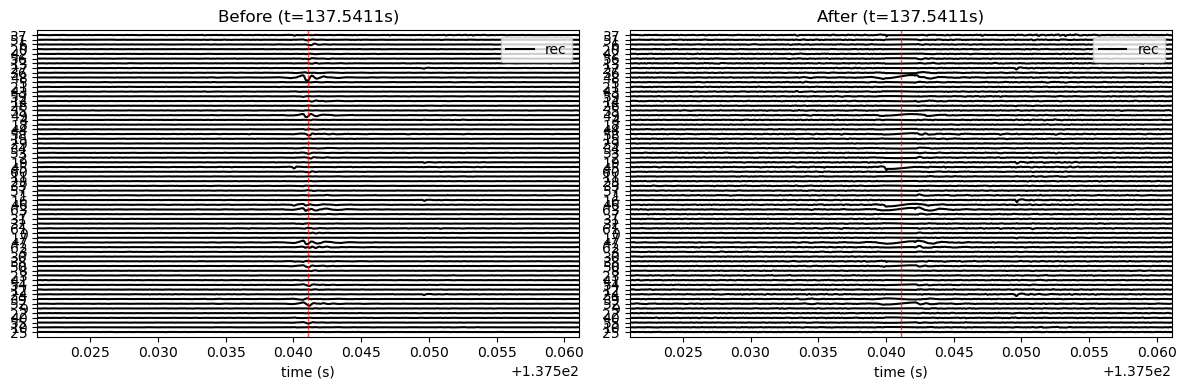

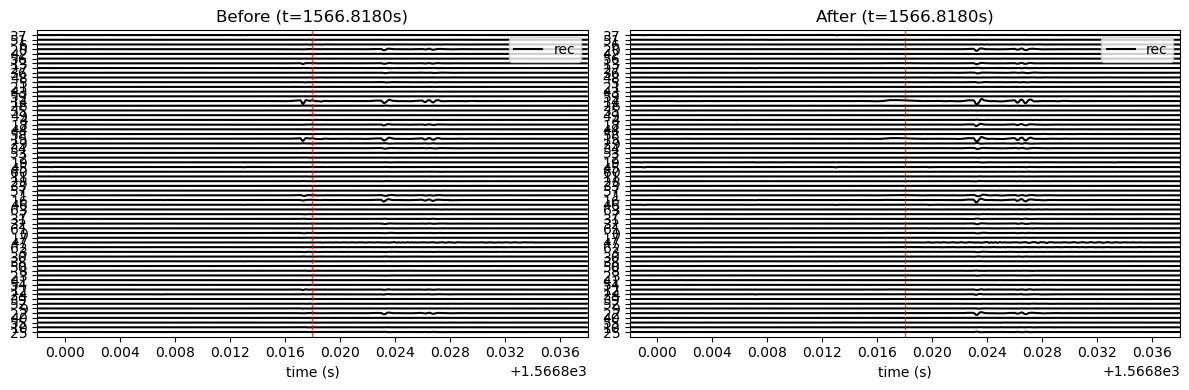

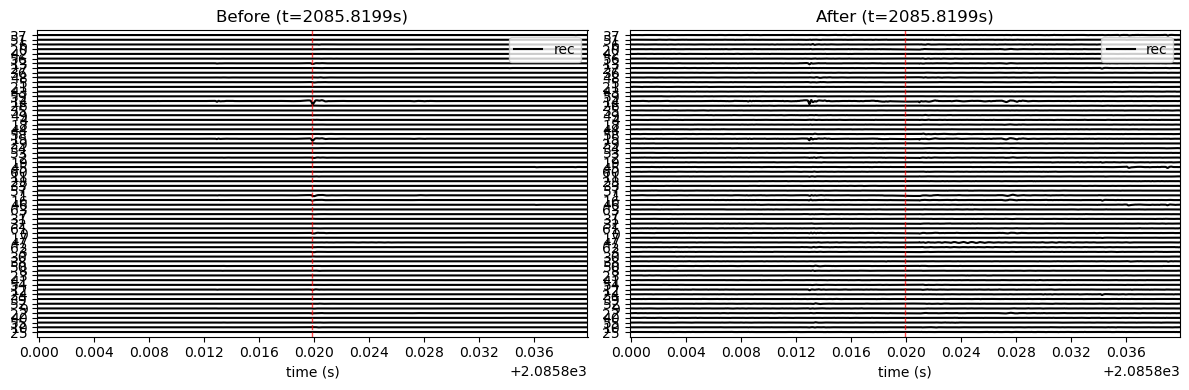

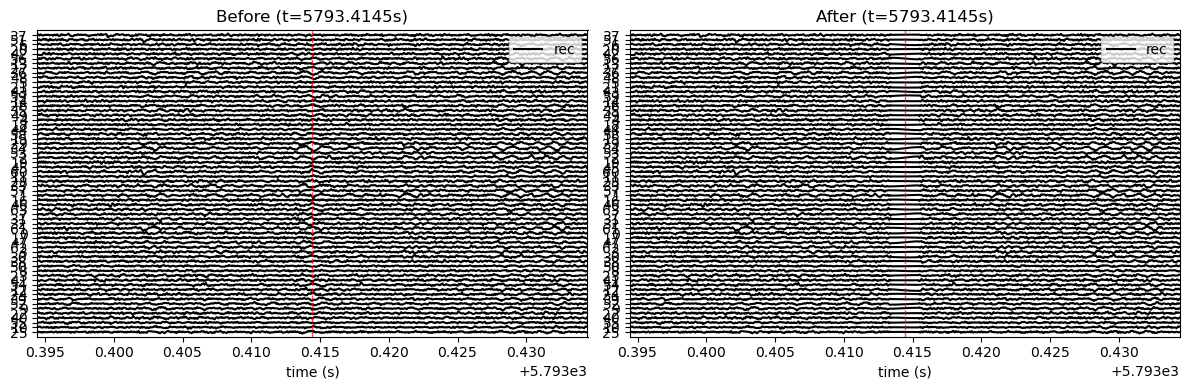

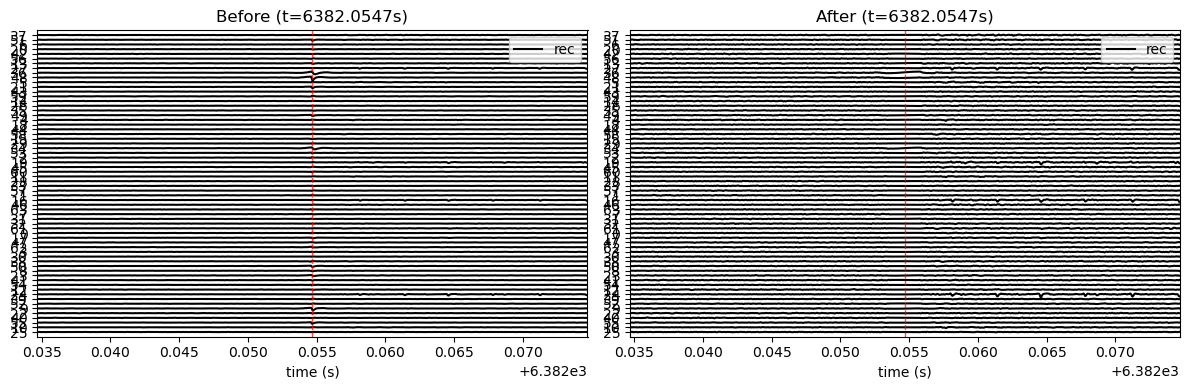

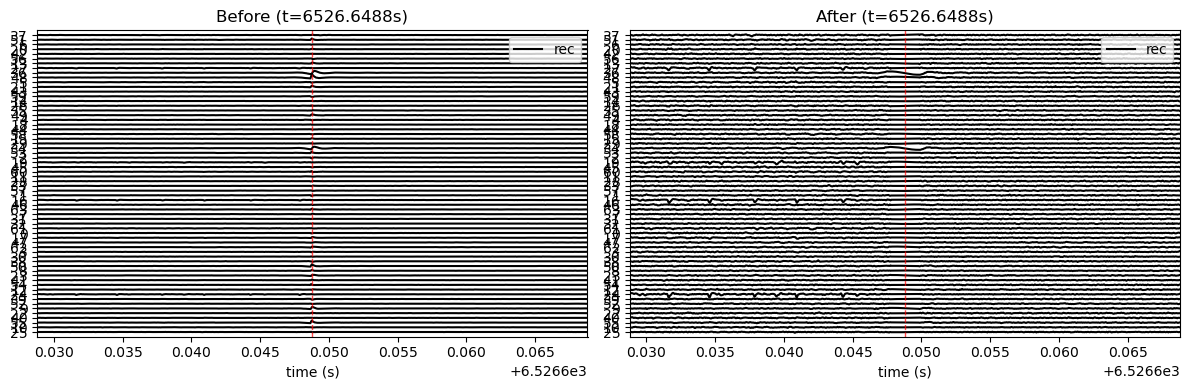

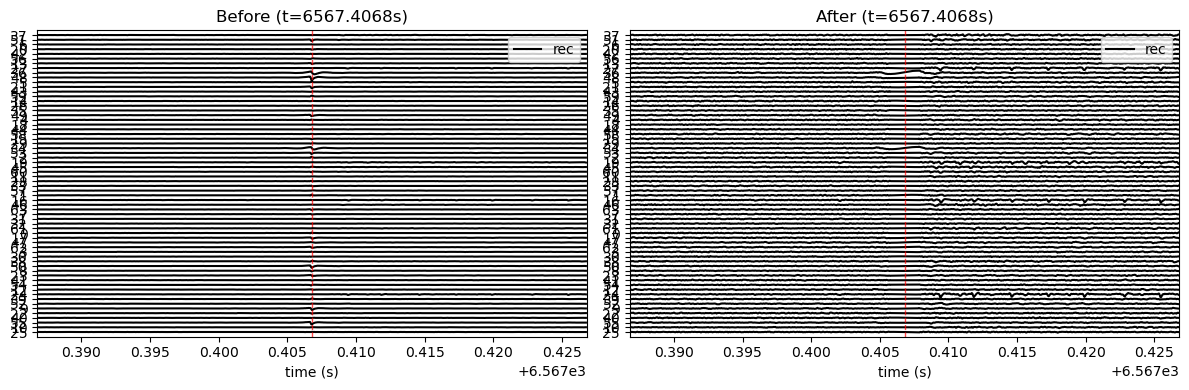

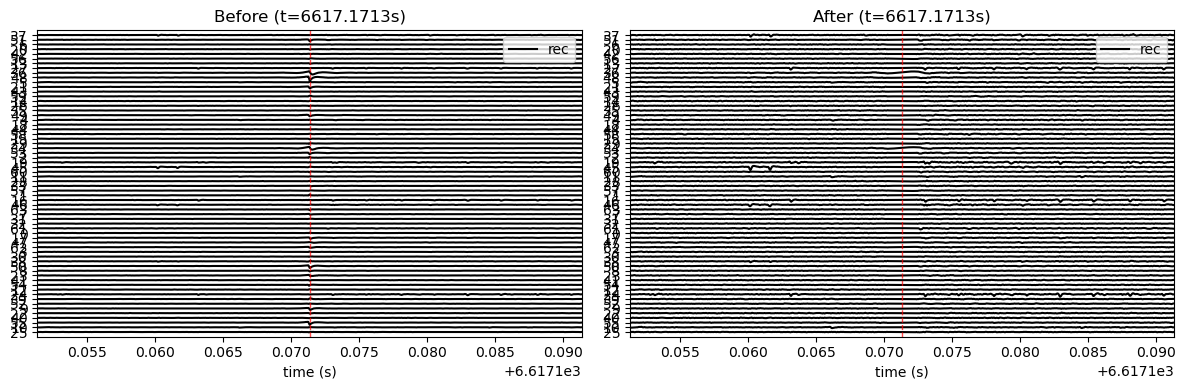

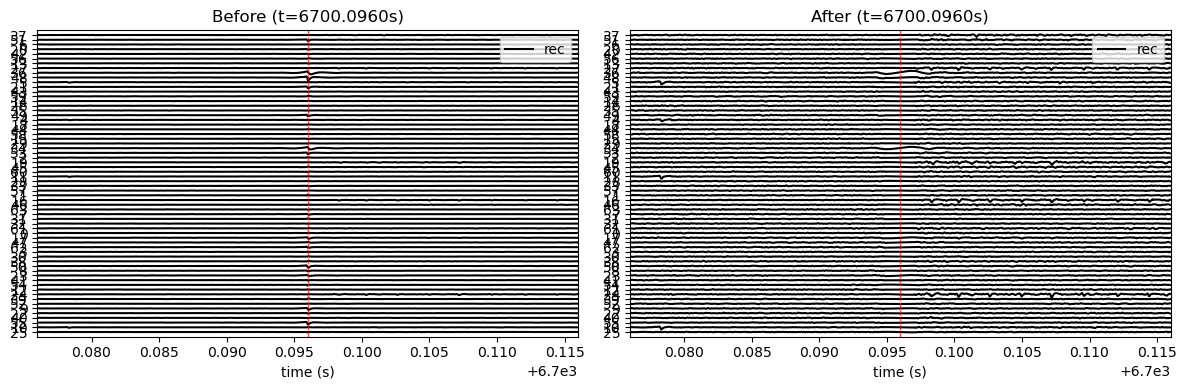

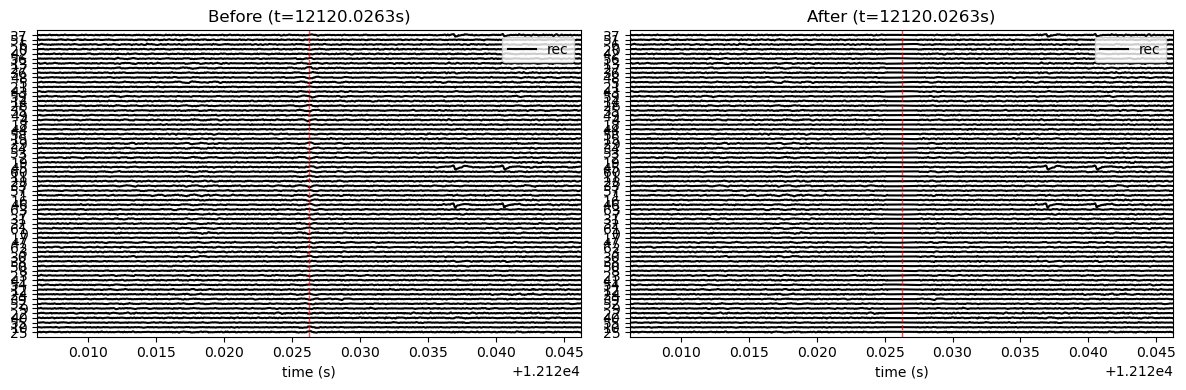

In [98]:
plot_traces_around_ttl_compare(
    recording_before=recording_cmr,
    recording_after=recording_clean,
    ttl_times=triggers[0],  
    # before_ms=10.0,
    # after_ms=10.0,
    before_ms=20.0,
    after_ms=20.0,
    units="frames",
    segment_index=0,
    channel_ids=recording_cmr.get_channel_ids(), 
    figsize=(12, 4),  
    n_max=10,                                     
)


## Spike Sorting

In [54]:
# recording_cmr = recording_cmr.frame_slice(start_frame=0, end_frame=int(1800*fs))

In [55]:
params = ss.get_default_sorter_params('kilosort4')
params

{'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'nt': 61,
 'shift': None,
 'scale': None,
 'batch_downsampling': 1,
 'artifact_threshold': inf,
 'nskip': 25,
 'whitening_range': 32,
 'highpass_cutoff': 300,
 'binning_depth': 5,
 'sig_interp': 20,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'nt0min': None,
 'dmin': None,
 'dminx': 32,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'max_channel_distance': 32,
 'max_peels': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_neighbors': 10,
 'cluster_downsampling': 1,
 'max_cluster_subset': 25000,
 'x_centers': None,
 'cluster_init_seed': 5,
 'duplicate_spike_ms': 0.25,
 'position_limit': 100,
 'do_CAR': True,
 'invert_sign': False,
 'save_extra_vars': False,
 'save_preprocessed_copy': False,
 'torch_device': 'auto',
 'bad_channels': None,
 'clear_cache': False,
 'do_correctio

In [56]:
# Waveform extraction and spike detection parameters
params['nt'] = 41                              # Number of timepoints per waveform (≈2 ms at 30 kHz; adjust with sampling rate)
params['nblocks'] = 0                          # Number of depth blocks for drift correction (0 disables drift correction)
params['batch_size'] = 160000                  # Number of samples per processing batch (larger improves drift estimation)
params['Th_single_ch'] = 4                     # Single-channel detection threshold (not a core Kilosort4 parameter)
params['Th_universal'] = 8                     # Universal template detection threshold (lower by 1–2 to detect more spikes)
params['Th_learned'] = 8                       # Learned template detection threshold (adjust similarly if spikes are missed)

# Template and clustering parameters
params['max_peels'] = 150                      # Maximum number of spike extraction iterations (internal limit, rarely changed)
params['nearest_templates'] = 150              # Number of nearest templates to consider for matching (≤ total channels)
params['n_templates'] = 10                     # Number of tracked templates (not a main Kilosort4 tuning parameter)
params['dmin'] = 20                            # Minimum vertical distance between template centers (µm)
params['dminx'] = 40                           # Minimum horizontal distance between template centers (µm)
params['nearest_chans'] = 12                   # Number of nearest channels used for spike detection and assignment

# Channel geometry and whitening parameters
params['max_channel_distance'] = 120           # Max distance for spatial search (used by SpikeInterface wrapper)
params['x_centers'] = 8                        # Number of x-position centers for template placement (≈200–300 µm spacing)
params['whitening_range'] = 24                 # Whitening range in channels (not commonly adjusted)
params['highpass_cutoff'] = 500                # High-pass filter cutoff frequency (Hz; part of preprocessing filter)

# Processing and optimization parameters
params['do_CAR'] = False                       # Disable common average referencing (already applied externally)
params['acg_threshold'] = 0.5                  # Autocorrelogram threshold for cluster quality (wrapper-level QC)
params['ccg_threshold'] = 0.0                  # Cross-correlogram threshold for QC (wrapper-level)
params['n_jobs'] = n_jobs                      # Number of parallel jobs (SpikeInterface parallelization, not core KS4)
params['delete_recording_dat'] = False         # Keep raw .dat file after sorting
params['clear_cache'] = True                   # Clear cached data to free memory after sorting


In [57]:
%%time
sorting = ss.run_sorter(
    sorter_name="kilosort4",
    recording=recording_clean,
    folder=basepath + '/kilosort4_after_artifact_removal',
    remove_existing_folder=True,
    with_output=True,
    **params
)

100%|██████████| 7/7 [06:34<00:00, 56.43s/it] 


CPU times: user 20min 50s, sys: 42.5 s, total: 21min 33s
Wall time: 21min 44s


## Postprocessing
### Remove duplicated spikes from same cluster
### Remove redundant clusters

In [58]:
# sorting = se.read_phy(basepath + '/kilosort4/sorter_output')
sorting = se.read_phy(basepath + '/kilosort4_after_artifact_removal/sorter_output')

In [59]:
# Remove duplicated spikes within 0.5ms of same cluster
sorting_removed_duplicates = scur.remove_duplicated_spikes(sorting, censored_period_ms=0.5)

# Create sorting analyzer for quality assessment
sa_tmp = si.create_sorting_analyzer(
    sorting_removed_duplicates,
    recording_cmr,
    format="memory",
    sparse=False
)

# Remove redundant units (putative duplicates)
sorting_clean, redundancy_info = scur.remove_redundant_units(
    sa_tmp, 
    align=False, 
    duplicate_threshold=0.5,
    remove_strategy="max_spikes",
    extra_outputs=True,
)
print(f"Removed {len(redundancy_info)} redundant cluster combinations.")

Removed 298 redundant cluster combinations.


### Calculare unit features

In [60]:
# Create or load sorting analyzer with computed features
# phydir = basepath + "/kilosort4"
phydir = basepath + "/kilosort4_after_artifact_removal"
analyzer_folder = Path(phydir + "/analyzer_cache")

if analyzer_folder.exists():
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)
    print("Loaded existing analyzer from disk.")
else:
    # Create new analyzer
    analyzer = si.create_sorting_analyzer(
        sorting=sorting_clean,
        recording=recording_cmr,
        format="binary_folder",   
        folder=analyzer_folder,
        overwrite=True,
        **job_kwargs,
    )

    # Compute all required features
    analyzer.compute(
        {
            "random_spikes": {"method": "uniform", "seed": 42},
            "waveforms": {},
            "templates": {},          
            "noise_levels": {},
            "spike_amplitudes": {},
            "principal_components": {"n_components": 7, "mode": "by_channel_local"},
            "template_metrics": {},       
            "template_similarity": {},    
            "correlograms": {},
            "spike_locations": {},
            "unit_locations": {},
        },
        **job_kwargs,  
    )
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)

Projecting waveforms: 100%|██████████| 290/290 [00:00<00:00, 731.75it/s]
Compute : spike_amplitudes + spike_locations (workers: 506 processes): 100%|██████████| 6065/6065 [00:12<00:00, 489.21it/s]


### Merge clusters

In [61]:
# Define merge criteria for clustering
steps_params = {
    "num_spikes": {           
        "min_spikes": 100,    
    },
    "correlogram": {
        "corr_diff_thresh": 0.25,
    },
    "template_similarity": {
        "template_diff_thresh": 0.25
    }
}

# Compute merge candidates based on similarity and correlograms
print("Computing merge candidates...")
merge_groups = scur.compute_merge_unit_groups(
    analyzer,                   
    preset="similarity_correlograms", 
    resolve_graph=True,               
    steps_params=steps_params    
)
print(f"Found {len(merge_groups)} groups to merge.")

Computing merge candidates...
Found 2 groups to merge.


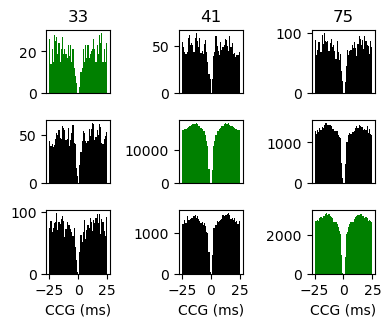

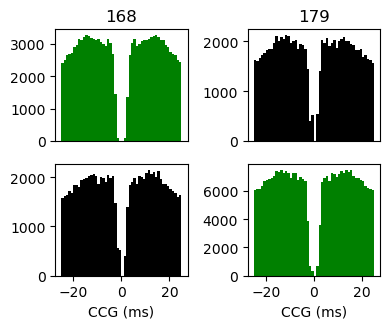

In [62]:
for i in range(len(merge_groups)):
    sw.plot_crosscorrelograms(
        sorting_analyzer_or_sorting=analyzer,
        unit_ids=merge_groups[i],            
        bin_ms=1,
        window_ms=25.0,
        figsize=(4, 3)
    )

In [63]:
# Check which unit groups can be safely merged
mergeable = analyzer.are_units_mergeable(
    merge_unit_groups=merge_groups,
    merging_mode="soft",
    sparsity_overlap=0.5
)

# Filter to only safely mergeable groups
merge_groups = [g for g, ok in mergeable.items() if ok]
nonmerge_groups = [g for g, ok in mergeable.items() if not ok]

# Create analyzer with merged units
analyzer_merged_folder = Path(phydir + "/analyzer_cache_merged")
if analyzer_merged_folder.exists():
    try:
        shutil.rmtree(analyzer_merged_folder)
    except:
        pass

if len(merge_groups)!=0:
    analyzer_merged = analyzer.merge_units(
        merge_unit_groups=merge_groups,
        merging_mode='soft', 
        censor_ms=0.5, 
        sparsity_overlap=0.5,
        return_new_unit_ids=False, 
        format="binary_folder", 
        folder=analyzer_merged_folder,
        overwrite=True,       
        **job_kwargs     
)
    
else:
    analyzer_merged = analyzer
    print("No units to merge.")

In [64]:
# Inspect principal_components extension output (for PC-based Mahalanobis option)
import numpy as np

pc_ext = analyzer_merged.get_extension('principal_components')
pc_data = pc_ext.get_data()
if isinstance(pc_data, list):
    pc_data = pc_data[0]

print('principal_components get_data() type:', type(pc_data))
if isinstance(pc_data, dict):
    print('keys:', list(pc_data.keys()))
    for k, v in pc_data.items():
        if isinstance(v, np.ndarray):
            print(f'  {k}: shape={v.shape} dtype={v.dtype}')
        else:
            print(f'  {k}: type={type(v)}')
elif isinstance(pc_data, np.ndarray):
    print('array shape:', pc_data.shape, 'dtype=', pc_data.dtype)
else:
    print('repr:', repr(pc_data)[:800])

principal_components get_data() type: <class 'numpy.ndarray'>
array shape: (113564, 7, 9) dtype= float32


### Split deviate waveforms

In [65]:
import numpy as np
import spikeinterface as si
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2

def autosplit_outliers(
    analyzer,
    # ---- Distance Gate Parameters (Main) ----
    contamination: float = 0.05,        # Expected fraction of outliers (force-removed if threshold_mode="empirical")
    threshold_mode: str = "empirical",  # Threshold logic: "empirical" (fixed %) | "mad" (robust, recommended) | "chi2"
    cov_estimator: str = "mcd",         # Covariance estimation: "mcd" (robust, core-only) | "empirical" (standard, full-data)
    per_cell: int = 500,                # Max spikes per time-bin for training covariance
    n_time_bins: int = 10,              # Number of time bins to sample from (handles drift)
    random_state: int = 42,             # Random seed
    min_clean_frac: float = 0.50,       # Safety: if >50% spikes are outliers, relax the threshold
    relax_factor: float = 0.5,          # Safety: relaxation factor when min_clean_frac is triggered

    # ---- Output Control ----
    drop_empty_parents: bool = True,           # Remove original unit ID if empty
    squeeze_all_outlier_to_new: bool = True,   # Move outliers to a new unit (True) or delete them (False)
    return_details: bool = False,              # Return debug dictionary
    verbose: bool = True,                      # Print progress

    # ---- Waveform Cosine Gate (Rescue) ----
    use_waveform_gate: bool = True,     # Enable waveform shape check
    wf_threshold: float = 0.9,          # Absolute Cosine Similarity Threshold (0.9+ is saved)
    wf_cand_max: int | None = 3000,     # Max candidates to check (None = check all)
    wf_ms_before: float = 1.0,          # ms before peak
    wf_ms_after: float = 2.0,           # ms after peak
    wf_n_chans: int = 20,               # Top N channels to use for comparison
    wf_center: str = "demean",          # "demean" (ignore offset) | "none"
):
    """
    Split per-unit outliers into NEW integer unit IDs.
    
    Logic:
      1. Mahalanobis Distance: Identifies statistical outliers based on amplitude/location features.
      2. Waveform Gate (Rescue): If an outlier has a waveform very similar (>= wf_threshold) 
         to the unit's template, it is rescued (kept as a valid spike).
    """

    rng = np.random.default_rng(random_state)

    # ==========================================================================
    #  1. Preparation & Data Loading
    # ==========================================================================
    sorting = analyzer.sorting
    fs = sorting.get_sampling_frequency()

    # Ensure single segment (Multi-segment support requires complex mapping)
    if hasattr(sorting, "get_num_segments") and sorting.get_num_segments() != 1:
        raise RuntimeError("This implementation currently supports only single-segment sortings.")

    # ---- Load Spike Vector ----
    try:
        sv = si.get_spike_vector(sorting)
    except:
        sv = sorting.to_spike_vector()
        
    # Robustly identify field names
    uid_field = "unit_id" if "unit_id" in sv.dtype.names else "unit_index"
    frm_field = "sample_index" if "sample_index" in sv.dtype.names else "frame"
    
    if frm_field not in sv.dtype.names:
        # Fallback search for frame field
        for f in ["sample_ind", "time_sample"]:
            if f in sv.dtype.names:
                frm_field = f
                break
    if frm_field not in sv.dtype.names:
        raise RuntimeError("Spike vector lacks frame field.")

    frames_all = sv[frm_field].astype(np.int64)

    # ---- Unit ID Handling (CRITICAL FIX) ----
    # Ensure uids_all contains actual Unit IDs, not indices
    if uid_field == "unit_id":
        uids_all = sv["unit_id"].astype(np.int64)
    else:
        unit_ids_orig = sorting.get_unit_ids()
        uidx = sv["unit_index"].astype(np.int64)
        try:
            # Create a map from index -> ID
            unit_ids_map = np.array([int(u) for u in unit_ids_orig], dtype=np.int64)
            uids_all = unit_ids_map[uidx]
        except:
            raise RuntimeError("Integer unit_ids required.")

    # ---- Load Features ----
    if not analyzer.has_extension("spike_amplitudes"):
        raise RuntimeError("Missing 'spike_amplitudes'.")
    amps = analyzer.get_extension("spike_amplitudes").get_data()
    if isinstance(amps, list): amps = amps[0]

    loc = None
    if analyzer.has_extension("spike_locations"):
        loc_data = analyzer.get_extension("spike_locations").get_data()
        if isinstance(loc_data, np.ndarray) and loc_data.ndim == 2:
            loc = loc_data[:, :2]
    if isinstance(loc, list): loc = loc[0]

    F_all = np.c_[amps] if loc is None else np.c_[amps, loc]
    
    # Validation check
    if F_all.shape[0] != uids_all.shape[0]:
        raise RuntimeError(f"Feature count ({F_all.shape[0]}) mismatch with Spike count ({uids_all.shape[0]}).")

    # Global Z-score
    Z_all = StandardScaler().fit_transform(F_all)

    # ---- Waveform Gate Prep ----
    recording = getattr(analyzer, "recording", None)
    templates = None
    uid_to_uindex = None

    if use_waveform_gate:
        if recording is None: raise RuntimeError("Analyzer needs recording.")
        if not analyzer.has_extension("templates"):
            analyzer.compute("templates", operators=["average"])
        
        ext_tmpl = analyzer.get_extension("templates")
        try: templates = ext_tmpl.get_data(operator="average")
        except: templates = ext_tmpl.get_data()
        
        unit_ids_order = sorting.get_unit_ids()
        uid_to_uindex = {int(uid): i for i, uid in enumerate(unit_ids_order)}

    # ==========================================================================
    #  2. Inner Helpers
    # ==========================================================================
    def _stratified_subsample(vals_amp, vals_time, n_bins, k_per, rng_):
        """Subsample spikes uniformly across time and amplitude."""
        N = vals_amp.size
        if N <= k_per: return np.arange(N)
        order_t = np.argsort(vals_time)
        edges_t = np.linspace(0, N, n_bins + 1, dtype=int)
        qedges = np.quantile(vals_amp, [0, 0.2, 0.4, 0.6, 0.8, 1.0])
        picks = []
        for bi in range(n_bins):
            seg = order_t[edges_t[bi]:edges_t[bi + 1]]
            if seg.size == 0: continue
            a = vals_amp[seg]
            for q0, q1 in zip(qedges[:-1], qedges[1:]):
                mask = (a >= q0) & (a < q1 if q1 < qedges[-1] else a <= q1)
                cand = seg[mask]
                if cand.size == 0: continue
                k = min(k_per, cand.size)
                picks.append(rng_.choice(cand, size=k, replace=False))
        if not picks: return rng_.choice(N, size=min(N, k_per), replace=False)
        return np.unique(np.concatenate(picks))

    def _fit_cov(Z_tr, estimator):
        """Fit covariance matrix."""
        if estimator.lower() == "mcd":
            try:
                if Z_tr.shape[0] > (Z_tr.shape[1] + 5):
                    return MinCovDet(random_state=random_state).fit(Z_tr)
            except: pass
        return EmpiricalCovariance(assume_centered=False).fit(Z_tr)

    def _extract_waveforms(rec, frs, ch_ids, nb, na):
        """Extract raw traces."""
        frs = frs.astype(np.int64)
        ns = nb + na
        nc = len(ch_ids)
        W = np.empty((frs.size, ns, nc), dtype=np.float32)
        for i, f in enumerate(frs):
            tr = rec.get_traces(start_frame=f-nb, end_frame=f+na, channel_ids=ch_ids, return_in_uV=True)
            if tr.shape[0] == ns: W[i] = tr
            else: W[i] = 0
        return W

    def _cosine_scores(W, tmpl_win, c_mode):
        """Calculate cosine similarity."""
        X = W.reshape(W.shape[0], -1)
        t = tmpl_win.reshape(-1)
        if c_mode == "demean":
            X = X - X.mean(axis=1, keepdims=True)
            t = t - t.mean()
        Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
        tn = t / (np.linalg.norm(t) + 1e-12)
        return (Xn @ tn)

    # ==========================================================================
    #  3. Main Loop
    # ==========================================================================
    orig_unit_ids = [int(u) for u in sorting.get_unit_ids()]
    max_existing = max(orig_unit_ids) if len(orig_unit_ids) > 0 else -1
    next_new_id = max_existing + 1
    units_dict = {}
    details = {}

    for uid in orig_unit_ids:
        # Filter spikes for this unit
        sel = (uids_all == uid)
        if not np.any(sel): continue
        
        Z = Z_all[sel]
        fr = frames_all[sel]
        n_total = int(Z.shape[0])

        # Skip small units (Pass through)
        if n_total < 50:
            units_dict[int(uid)] = fr
            details[int(uid)] = {"n_total": n_total, "action": "passthrough_small"}
            continue

        # --- A. Distance Gate ---
        amp_u = F_all[sel, 0]
        sub_idx = _stratified_subsample(amp_u, fr, n_time_bins, per_cell, rng)
        cov = _fit_cov(Z[sub_idx], cov_estimator)
        d2 = cov.mahalanobis(Z)
        
        # Thresholding
        if threshold_mode == "empirical":
            thr_d = np.quantile(d2, 1.0 - contamination)
        elif threshold_mode == "mad":
            med = np.median(d2)
            mad = 1.4826 * np.median(np.abs(d2 - med))
            thr_d = med + 3.5 * mad
        elif threshold_mode == "calibrated_chi2":
            chi2_med = chi2.ppf(0.5, df=Z.shape[1])
            scale = np.median(d2) / chi2_med if chi2_med > 0 else 1.0
            thr_d = scale * chi2.ppf(1.0 - contamination, df=Z.shape[1])

        out_mask = d2 > thr_d
        
        # Safety Relax
        n_out = out_mask.sum()
        if (n_total - n_out) / n_total < min_clean_frac:
            c_relax = max(1e-4, contamination * relax_factor)
            thr_d = np.quantile(d2, 1.0 - c_relax)
            out_mask = d2 > thr_d

        # --- B. Waveform Refinement (Fixed Threshold) ---
        wf_used = False
        if use_waveform_gate and templates is not None and uid in uid_to_uindex:
            cand_mask = out_mask.copy()
            cand_idx = np.flatnonzero(cand_mask)

            # Check if we have candidates to potentially rescue
            if cand_idx.size > 0:
                nb = int(round(wf_ms_before * fs / 1000.0))
                na = int(round(wf_ms_after * fs / 1000.0))
                n_samp = recording.get_num_samples(segment_index=0)
                valid = (fr - nb >= 0) & (fr + na <= n_samp)
                
                # Check valid candidates (within recording bounds)
                c_eval = cand_idx[valid[cand_idx]]

                if c_eval.size > 0:
                    tmpl_full = templates[uid_to_uindex[uid]]
                    
                    # Channel Selection
                    ptp = np.ptp(tmpl_full, axis=0)
                    ch_inds = np.argsort(ptp)[-wf_n_chans:][::-1] if wf_n_chans < ptp.size else np.arange(ptp.size)
                    ch_ids = [recording.get_channel_ids()[i] for i in ch_inds]
                    tmpl_sub = tmpl_full[:, ch_inds]

                    # Alignment
                    peak_idx = np.argmax(np.max(np.abs(tmpl_sub), axis=1))
                    t_start = peak_idx - nb
                    t_end = peak_idx + na
                    
                    if t_start >= 0 and t_end <= tmpl_sub.shape[0]:
                        tmpl_win = tmpl_sub[t_start:t_end, :]

                        # Limit Candidates if needed
                        if wf_cand_max is None:
                            c_pick = c_eval
                        else:
                            if c_eval.size > wf_cand_max:
                                c_pick = rng.choice(c_eval, size=int(wf_cand_max), replace=False)
                            else:
                                c_pick = c_eval
                        
                        # Extract & Score
                        W_cand = _extract_waveforms(recording, fr[c_pick], ch_ids, nb, na)
                        s_cand = _cosine_scores(W_cand, tmpl_win, wf_center)
                        
                        # Rescue: If score >= fixed threshold, unmark outlier
                        cand_bad = s_cand < wf_threshold
                        rescued_idx = c_pick[~cand_bad]
                        out_mask[rescued_idx] = False
                        wf_used = True

        # --- C. Output Construction ---
        cln_fr = fr[~out_mask]
        nz_fr = fr[out_mask]
        
        if nz_fr.size == 0:
            units_dict[int(uid)] = cln_fr
            details[int(uid)] = {"action": "no_split"}
        elif cln_fr.size == 0:
            if squeeze_all_outlier_to_new:
                new_id = next_new_id
                next_new_id += 1
                units_dict[new_id] = nz_fr
                if not drop_empty_parents: units_dict[int(uid)] = np.array([], dtype=np.int64)
                details[int(uid)] = {"action": "all_moved"}
            else:
                units_dict[int(uid)] = nz_fr
                details[int(uid)] = {"action": "keep_all_noise"}
        else:
            units_dict[int(uid)] = cln_fr
            new_id = next_new_id
            next_new_id += 1
            units_dict[new_id] = nz_fr
            details[int(uid)] = {"action": "split", "wf_used": wf_used}
            if verbose:
                print(f"UID {uid}: split {cln_fr.size} clean, {nz_fr.size} outliers -> {new_id}")

    # ==========================================================================
    #  4. Reconstruct Sorting (Safer)
    # ==========================================================================
    
    valid_uids = sorted(units_dict.keys())
    spikes = []
    labels = []
    
    for u in valid_uids:
        t = units_dict[u]
        if t.size > 0:
            spikes.append(t)
            labels.append(np.full(t.size, u, dtype=np.int64))
    
    if spikes:
        times_concat = np.concatenate(spikes)
        labels_concat = np.concatenate(labels)
        
        # Explicit sorting by time is required for many SI/Phy operations
        order = np.argsort(times_concat)
        times_concat = times_concat[order]
        labels_concat = labels_concat[order]
        sorting_out = si.NumpySorting.from_samples_and_labels(times_concat, labels_concat, fs)
    else:
        sorting_out = si.NumpySorting(fs, [])

    return (sorting_out, details) if return_details else sorting_out

In [66]:
sorting_split = autosplit_outliers(
    analyzer_merged,
    # ---- distance (Mahalanobis) gate ----
    contamination=0.05,
    threshold_mode="calibrated_chi2",
    cov_estimator="empirical",
    per_cell=500,
    n_time_bins=10,
    random_state=42,
    min_clean_frac=0.9,
    relax_factor=0.5,
    # ---- waveform cosine gate ----
    use_waveform_gate=True,        
    wf_threshold=0.2,          
    wf_cand_max=None,            
    wf_ms_before=1.0,            
    wf_ms_after=2.0,             
    wf_n_chans=10,               
    wf_center="demean", 
    drop_empty_parents=True,
    squeeze_all_outlier_to_new=True,
    return_details=False,
    verbose=True,
         
)


UID 0: split 6205 clean, 536 outliers -> 357
UID 3: split 228 clean, 6 outliers -> 358
UID 5: split 30176 clean, 1056 outliers -> 359
UID 6: split 25645 clean, 2059 outliers -> 360
UID 7: split 1082 clean, 102 outliers -> 361
UID 8: split 992 clean, 4 outliers -> 362
UID 12: split 140 clean, 4 outliers -> 363
UID 15: split 16533 clean, 424 outliers -> 364
UID 16: split 79890 clean, 146 outliers -> 365
UID 17: split 33069 clean, 631 outliers -> 366
UID 18: split 1763 clean, 27 outliers -> 367
UID 20: split 695 clean, 8 outliers -> 368
UID 22: split 9546 clean, 245 outliers -> 369
UID 23: split 9259 clean, 238 outliers -> 370
UID 24: split 11730 clean, 90 outliers -> 371
UID 26: split 825 clean, 1 outliers -> 372
UID 29: split 74 clean, 4 outliers -> 373
UID 31: split 337 clean, 4 outliers -> 374
UID 32: split 1919 clean, 3 outliers -> 375
UID 34: split 212 clean, 19 outliers -> 376
UID 35: split 10165 clean, 257 outliers -> 377
UID 36: split 15397 clean, 16 outliers -> 378
UID 38: split

In [67]:

analyzer_split = si.create_sorting_analyzer(
    sorting=sorting_split,
    recording=recording_cmr,
    format="memory",   
    folder=analyzer_folder,
    overwrite=True,
    **job_kwargs,
)

# Compute all required features
analyzer_split.compute(
    {
        "random_spikes": {"method": "uniform", "seed": 42},
        "waveforms": {},
        "templates": {},          
        "noise_levels": {},
        "spike_amplitudes": {},
        "principal_components": {"n_components": 7, "mode": "by_channel_local"},
        "template_metrics": {},       
        "template_similarity": {},    
        "correlograms": {},
        "spike_locations": {},
        "unit_locations": {},
    },
    **job_kwargs,  
)


Projecting waveforms: 100%|██████████| 522/522 [00:00<00:00, 718.95it/s]
/local/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/postprocessing/template_metrics.py:644: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = scipy.stats.linregress(times[peak_idx:max_idx], template_single[peak_idx:max_idx])
Compute : spike_amplitudes + spike_locations (workers: 506 processes): 100%|██████████| 6065/6065 [00:14<00:00, 417.79it/s]


### Calcurate quality metrics and export for manual curation

In [73]:
# Get default quality metric parameters
qm_params = sqm.get_default_qm_params()

# Compute quality metrics for all units
metrics_df = sqm.compute_quality_metrics(
    analyzer_split,
    metric_names=['isi_violation', 'presence_ratio', 'snr', 'amplitude_median'],
    metric_params=qm_params,
    skip_pc_metrics=True,  # PCs are computed above
    n_jobs=n_jobs,
    progress_bar=True
)

In [74]:
# Export sorting results to Phy format for manual curation
# phydir2 = basepath + "/kilosort4_postprocess"
phydir2 = basepath + "/kilosort4_after_artifact_removal_postprocess"
export_to_phy(
    sorting_analyzer=analyzer_split,
    output_folder=phydir2,
    compute_pc_features=True,  
    compute_amplitudes=True,    
    copy_binary=False,           
    remove_if_exists=True,
    template_mode='average',
    add_quality_metrics=True,
    add_template_metrics=True,
    dtype=None,
    use_relative_path=True,
    verbose=True,
    **job_kwargs
)

# Fix params.py for Phy
params_file = Path(phydir2) / "params.py"

with open(params_file, 'r') as f:
    content = f.read()

# 1. Set dat_path to concatenated binary file
dat_relative_path = glob.glob(basepath + '/*.dat')[0]
content = content.replace("dat_path = None", f"dat_path = [r'{dat_relative_path}']")

# 2. Set hp_filtered flag (data is already filtered)
new_hp_line = "hp_filtered = False"
if re.search(r"hp_filtered\s*=", content):
    content = re.sub(r"hp_filtered\s*=.*", new_hp_line, content)
else:
    content += f"\n{new_hp_line}"

# Write updated params back
with open(params_file, 'w') as f:
    f.write(content)

print(f"Fixed dat_path in {params_file}")
print(f"Set dat_path to: {dat_relative_path}")

extract PCs (workers: 506 processes): 100%|██████████| 6065/6065 [00:13<00:00, 443.71it/s]


Run:
phy template-gui  /local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/kilosort4_after_artifact_removal_postprocess/params.py
Fixed dat_path in /local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/kilosort4_after_artifact_removal_postprocess/params.py
Set dat_path to: /local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_day03.dat


In [75]:
def mark_noise_clusters_from_metrics(
    phy_dir: str | Path,
    metrics_df: pd.DataFrame,
    thresholds: dict,
    backup: bool = True,
    reset_to_unsorted: bool = True,
) -> pd.DataFrame:
    """
    Update Phy's `cluster_group.tsv` to mark `group = "noise"` based on quality metrics.

    Parameters
    ----------
    phy_dir : str | Path
        Phy output folder containing `cluster_group.tsv` and `cluster_si_unit_ids.tsv`.
    metrics_df : pd.DataFrame
        DataFrame indexed by SI unit_id (or with a 'cluster_id'/'si_unit_id' column) that contains:
        - isi_violations_ratio
        - isi_violations_count
        - presence_ratio
        - snr
        - amplitude_median
    thresholds : dict
        Rules to mark noise. Supported keys (use any subset):
        - "isi_violations_ratio_gt": float  # mark noise if ratio > value
        - "isi_violations_count_gt": int    # mark noise if count > value
        - "presence_ratio_lt": float        # mark noise if presence < value
        - "snr_lt": float                   # mark noise if snr < value
        - "amplitude_median_lt": float    # mark noise if abs(amplitude_median) < value
    backup : bool
        If True, make a timestamped backup of the original TSV before overwriting.
    reset_to_unsorted : bool
        If True, reset all existing labels to "unsorted" before applying new noise labels.

    Returns
    -------
    pd.DataFrame
        The updated `cluster_group.tsv` contents as a DataFrame sorted by cluster_id.
    """
    phy_dir = Path(phy_dir)

    # --- 1) Map cluster_id (Phy) <-> si_unit_id (SpikeInterface)
    map_path = phy_dir / "cluster_si_unit_ids.tsv"
    if not map_path.exists():
        raise FileNotFoundError(f"Mapping not found: {map_path}")
    mapping = pd.read_csv(map_path, sep="\t")  # columns: cluster_id, si_unit_id
    mapping["cluster_id"] = pd.to_numeric(mapping["cluster_id"], errors="coerce").astype("Int64")
    mapping["si_unit_id"] = pd.to_numeric(mapping["si_unit_id"], errors="coerce")

    # --- 2) Normalize metrics_df to have a 'si_unit_id' column, then join mapping to get cluster_id
    df = metrics_df.copy()
    if "si_unit_id" not in df.columns and "cluster_id" not in df.columns:
        # assume index is SI unit_id
        df.index.name = "si_unit_id"
        df = df.reset_index()
    if "cluster_id" in df.columns and "si_unit_id" not in df.columns:
        # rare case: metrics already in cluster_id space
        df = df.merge(mapping, on="cluster_id", how="inner")
    else:
        df = df.merge(mapping, on="si_unit_id", how="inner")
    df["cluster_id"] = pd.to_numeric(df["cluster_id"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["cluster_id"]).set_index("cluster_id").sort_index()

    # --- 3) Build boolean masks for each rule (missing columns are treated as NaN -> False)
    # Normalize amplitude to absolute if requested
    df["_amp_abs_"] = np.abs(df["amplitude_median"]) if "amplitude_median" in df.columns else np.nan

    conds = []
    # ISI violations: both ratio AND count must exceed thresholds (AND condition)
    if ("isi_violations_ratio_gt" in thresholds and "isi_violations_count_gt" in thresholds and
        "isi_violations_ratio" in df.columns and "isi_violations_count" in df.columns):
        isi_cond = ((df["isi_violations_ratio"] > thresholds["isi_violations_ratio_gt"]) &
                   (df["isi_violations_count"] > thresholds["isi_violations_count_gt"]))
        conds.append(isi_cond)
    elif "isi_violations_ratio_gt" in thresholds and "isi_violations_ratio" in df.columns:
        conds.append(df["isi_violations_ratio"] > thresholds["isi_violations_ratio_gt"])
    elif "isi_violations_count_gt" in thresholds and "isi_violations_count" in df.columns:
        conds.append(df["isi_violations_count"] > thresholds["isi_violations_count_gt"])
    
    if "presence_ratio_lt" in thresholds and "presence_ratio" in df.columns:
        conds.append(df["presence_ratio"] < thresholds["presence_ratio_lt"])
    if "snr_lt" in thresholds and "snr" in df.columns:
        conds.append(df["snr"] < thresholds["snr_lt"])
    if "amplitude_median_lt" in thresholds and "_amp_abs_" in df.columns:
        conds.append(df["_amp_abs_"] < thresholds["amplitude_median_lt"])

    noise_mask = pd.concat(conds, axis=1).any(axis=1) if conds else pd.Series(False, index=df.index)

    # --- 4) Read or create cluster_group.tsv (Phy expects: cluster_id<TAB>group)
    cg_path = phy_dir / "cluster_group.tsv"
    if cg_path.exists():
        cg = pd.read_csv(cg_path, sep="\t")
        if not {"cluster_id", "group"}.issubset(set(cg.columns)):
            raise ValueError("cluster_group.tsv must have columns: 'cluster_id', 'group'")
    else:
        # initialize as 'unsorted' for all clusters listed in mapping
        cg = pd.DataFrame({"cluster_id": mapping["cluster_id"], "group": "unsorted"})

    cg["cluster_id"] = pd.to_numeric(cg["cluster_id"], errors="coerce").astype("Int64")
    cg = cg.set_index("cluster_id")

    # --- 5) Reset all to unsorted if requested, then apply noise labels
    if reset_to_unsorted:
        cg["group"] = "unsorted"
    else:
        cg.loc[df.index, "group"] = cg.loc[df.index, "group"].fillna("unsorted")
    
    cg.loc[noise_mask.index[noise_mask], "group"] = "noise"

    # --- 6) Save (with backup)
    out_df = cg.reset_index().sort_values("cluster_id")
    if backup and cg_path.exists():
        bak = cg_path.with_suffix(".bak.tsv")
        shutil.copyfile(cg_path, bak)
    out_df.to_csv(cg_path, sep="\t", index=False)

    return out_df

In [76]:
# Define quality thresholds for automatic noise cluster labeling
th = dict(
    isi_violations_ratio_gt=3,         # Mark as noise if ISI ratio > 3
    isi_violations_count_gt=50,        # AND violation count > 50
    presence_ratio_lt=0.1,             # OR presence ratio < 0.1
    snr_lt=0.3,                        # OR SNR < 0.3
    amplitude_median_lt=25.0,          # OR absolute amplitude < 25 µV
)

# Apply automatic noise labeling
updated = mark_noise_clusters_from_metrics(phydir2, metrics_df, th, backup=False)
n_noise = (updated["group"] == "noise").sum()
print(f"# of noise clusters: {n_noise}")

# of noise clusters: 295


In [ ]:
def interpolate_short_nans(df, max_gap_s=1.0):
    """
    Linearly interpolate NaN segments in 'x' and 'y' columns that are shorter than max_gap_s.
    """
    df_interp = df.copy()
    timestamps = df.timestamps.values
    
    for coord in ['x', 'y']:
        values = df_interp[coord].values
        is_nan = np.isnan(values)
        
        # Find runs of NaNs
        # Pad to handle edge cases
        padded = np.concatenate(([False], is_nan, [False]))
        diff = np.diff(padded.astype(int))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        
        count_interpolated = 0
        
        for start, end in zip(starts, ends):
            # start is index of first NaN
            # end is index of first valid after NaN
            
            if start == 0 or end == len(timestamps):
                # Skip NaNs at the very beginning or end of recording
                continue
                
            # Calculate gap duration based on surrounding valid timestamps
            gap_duration = timestamps[end] - timestamps[start - 1]
            
            if gap_duration <= max_gap_s:
                # Interpolate
                t_start = timestamps[start-1]
                t_end = timestamps[end]
                v_start = values[start-1]
                v_end = values[end]
                
                t_targets = timestamps[start:end]
                
                # Linear interpolation
                interpolated = v_start + (v_end - v_start) * (t_targets - t_start) / (t_end - t_start)
                
                values[start:end] = interpolated
                count_interpolated += 1
        
        df_interp[coord] = values
        print(f"Interpolated {count_interpolated} gaps in '{coord}' (<= {max_gap_s}s)")
        
    return df_interp
position_df = loading.load_animal_behavior(basePath) 
# Apply interpolation
position_df_cleaned = interpolate_short_nans(position_df, max_gap_s=1.0)

# Update nelpy objects with cleaned data
pos = nel.AnalogSignalArray(
    data=position_df_cleaned[["x", "y"]].values.T,
    timestamps=position_df_cleaned.timestamps.values,
)
# Recalculate speed
speed = nel.utils.ddt_asa(pos, smooth=True, sigma=0.250, norm=True)

NameError: name 'loading' is not defined